# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Building-a-Convolutional-Neural-Network" data-toc-modified-id="Building-a-Convolutional-Neural-Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building a Convolutional Neural Network</a></div><div class="lev2 toc-item"><a href="#Model-Definition" data-toc-modified-id="Model-Definition-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Model Definition</a></div><div class="lev2 toc-item"><a href="#Data-Generator" data-toc-modified-id="Data-Generator-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data Generator</a></div><div class="lev2 toc-item"><a href="#Training" data-toc-modified-id="Training-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Training</a></div><div class="lev2 toc-item"><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data Augmentation</a></div><div class="lev1 toc-item"><a href="#Visualizing-Feature-Maps" data-toc-modified-id="Visualizing-Feature-Maps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizing Feature Maps</a></div><div class="lev1 toc-item"><a href="#Dense-Layer-Visualization" data-toc-modified-id="Dense-Layer-Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dense Layer Visualization</a></div><div class="lev1 toc-item"><a href="#Visualizing-Convnet-Filters" data-toc-modified-id="Visualizing-Convnet-Filters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualizing Convnet Filters</a></div>

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Note: The vis module (keras-vis) has been deprecated;
# If you need visualization, consider using tf-explain or other alternatives.


# Utility Functions

In [7]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])  # 'acc' has been changed to 'accuracy'
    accuracy = smooth_curve(history.history['accuracy'][:steps])
    val_accuracy = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Training Loss')
    plt.plot(val_loss, c='#e60505', label='Validation Loss')
    plt.plot(accuracy, c='#6aa84f', label='Training Accuracy')
    plt.plot(val_accuracy, c='#e69138', label='Validation Accuracy')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss/Accuracy', fontsize=12)
    plt.title('Training & Validation Loss/Accuracy', fontsize=12)
    plt.legend()

def deprocess_image(x):
    # Normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # Clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # Convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')


# Building a Convolutional Neural Network

## Model Definition

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_1 (MaxPooling2D)             │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_2 (MaxPooling2D)             │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_3 (MaxPooling2D)             │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool_4 (MaxPooling2D)             │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,681,345 (21.67 MB)

 Trainable params: 5,681,345 (21.67 MB)

 Non-trainable params: 0 (0.00 B)

## Data Generator

In [ ]:
!kaggle datasets download -d jhe2918/cats-and-dogs-small

Dataset URL: https://www.kaggle.com/datasets/jhe2918/cats-and-dogs-small

License(s): unknown


 93% 81.0M/86.7M [00:00<00:00, 92.6MB/s]

100% 86.7M/86.7M [00:00<00:00, 100MB/s] 


In [ ]:
%%capture
!unzip cats-and-dogs-small.zip -d /content/cats_and_dogs_small/

In [ ]:
## !rm -rf /content/cats_and_dogs_small

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

base_dir = '/content/cats_and_dogs_small/cats_and_dogs_small' # Make sure this path is correct
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory=train_dir,  # Use the variable train_dir
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        directory=validation_dir,  # Use the variable validation_dir
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=False)

# Print the class indices from the generators
print("Training classes:", train_generator.class_indices)
print("Validation classes:", validation_generator.class_indices)
print("Testing classes:", test_generator.class_indices)

# Check if the number of samples in each generator is as expected
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of testing samples:", test_generator.samples)

Found 2000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.

Training classes: {'cats': 0, 'dogs': 1}

Validation classes: {'cats': 0, 'dogs': 1}

Testing classes: {'cats': 0, 'dogs': 1}

Number of training samples: 2000

Number of validation samples: 1000

Number of testing samples: 1000


In [ ]:
!ls /content/cats_and_dogs_small/cats_and_dogs_small/validation # List the contents of the validation directory

cats  dogs


## Training

In [ ]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=20,
                              validation_data=validation_generator, verbose=1)

Epoch 1/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8354 - loss: 0.3662 - val_accuracy: 0.7390 - val_loss: 0.5705

Epoch 2/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8511 - loss: 0.3449 - val_accuracy: 0.7160 - val_loss: 0.6372

Epoch 3/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8684 - loss: 0.3169 - val_accuracy: 0.7310 - val_loss: 0.5684

Epoch 4/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8717 - loss: 0.2915 - val_accuracy: 0.7290 - val_loss: 0.6301

Epoch 5/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8930 - loss: 0.2626 - val_accuracy: 0.7360 - val_loss: 0.5648

Epoch 6/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9138 - loss: 0.2329 - val_accuracy: 0.7410 - val_loss: 0.6238

Epoch 7/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9188 - loss: 0.1987 - val_accuracy: 0.7410 - val_loss: 0.5995

Epoch 8/20

100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9195 - loss: 0.

In [ ]:
model.save('model.h5')
save_history(history, 'history.bin')

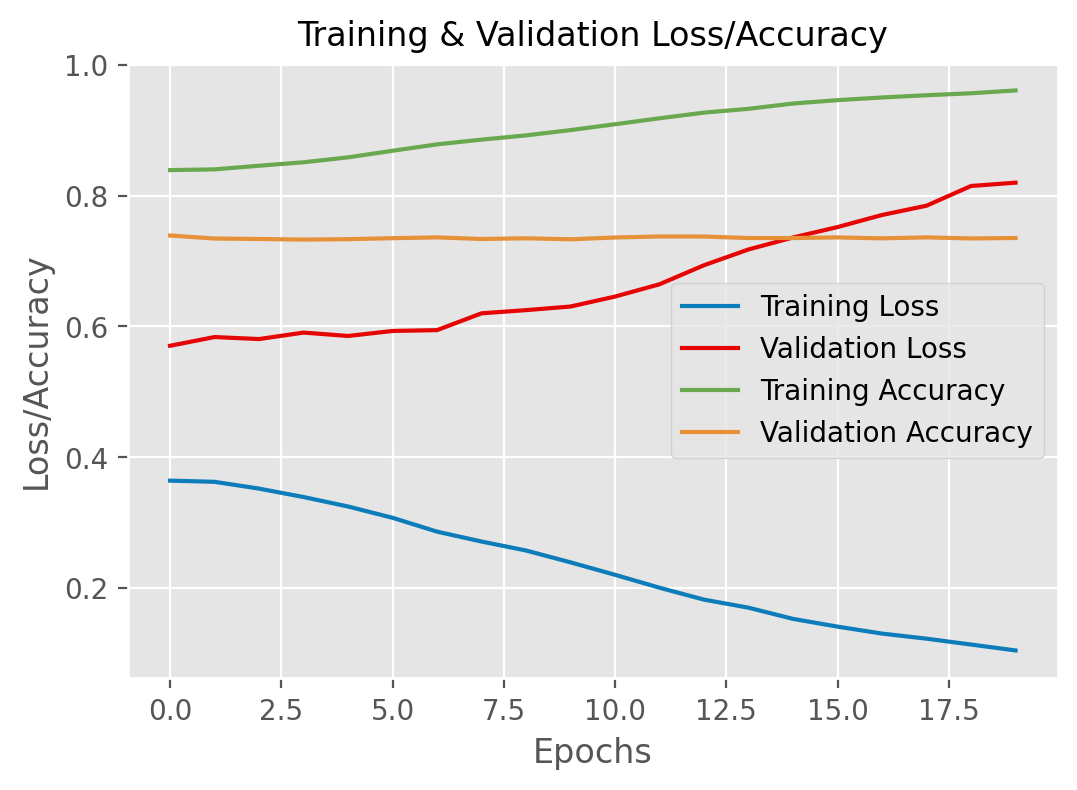

In [ ]:
history = load_history('history.bin')
plot_compare(history)

## Data Augmentation

In [ ]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [ ]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        directory=validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.


In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
                                      validation_data=validation_generator, validation_steps=50, verbose=1)

Epoch 1/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.5561 - loss: 0.6874 - val_accuracy: 0.5740 - val_loss: 0.6691

Epoch 2/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.5596 - loss: 0.6761 - val_accuracy: 0.6030 - val_loss: 0.6562

Epoch 3/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.5928 - loss: 0.6657 - val_accuracy: 0.5950 - val_loss: 0.6671

Epoch 4/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.5623 - loss: 0.6861 - val_accuracy: 0.5670 - val_loss: 0.6735

Epoch 5/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - accuracy: 0.5847 - loss: 0.6747 - val_accuracy: 0.5920 - val_loss: 0.6677

Epoch 6/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.5741 - loss: 0.6756 - val_accuracy: 0.5910 - val_loss: 0.6683

Epoch 7/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.5673 - loss: 0.6792 - val_accuracy: 0.5890 - val_loss: 0.6670

Epoch 8/60

100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0

In [ ]:
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

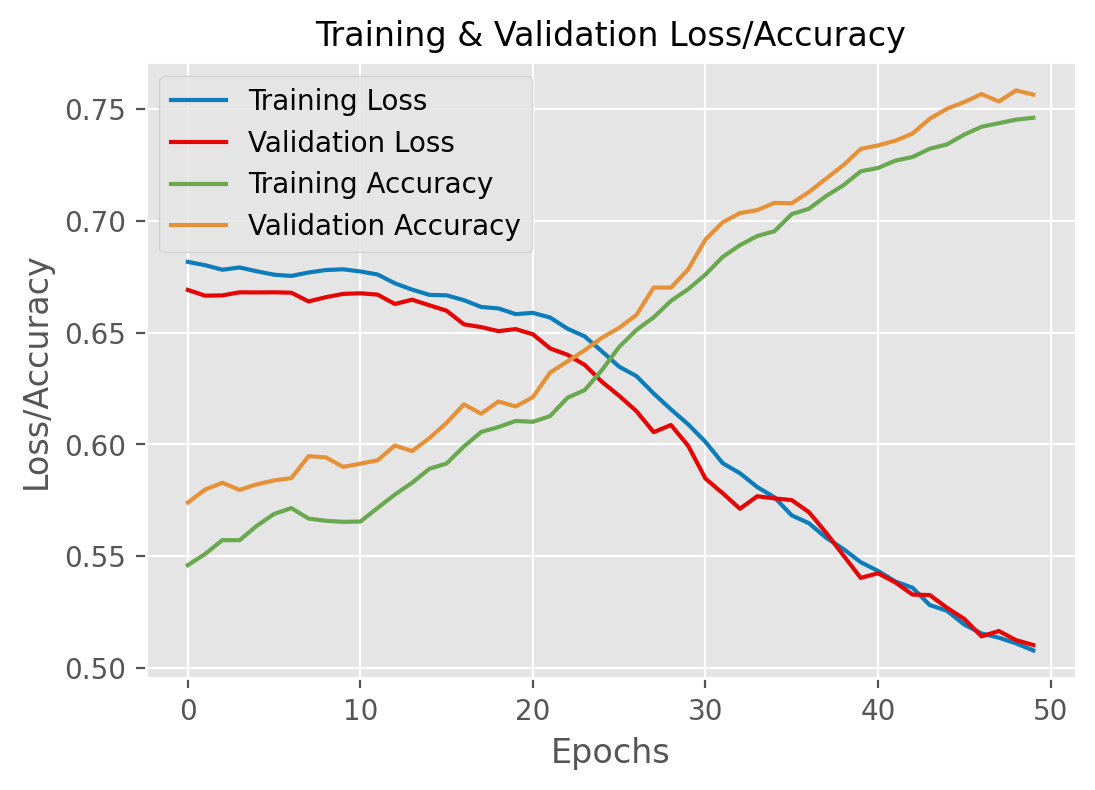

In [ ]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

# Visualizing Feature Maps

In [ ]:
img_path = '/content/cats_and_dogs_small/cats_and_dogs_small/train/cats/cat.54.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


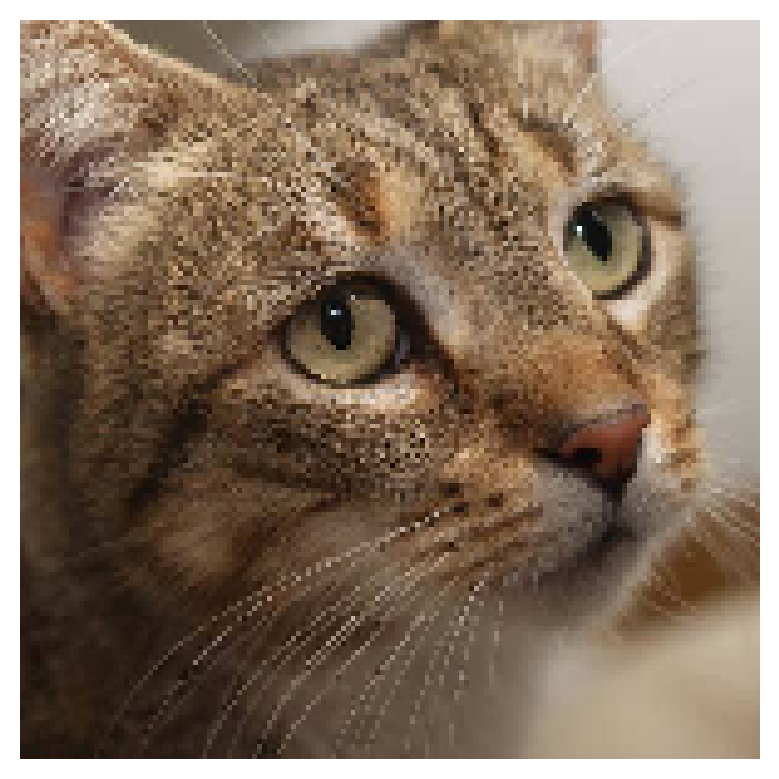

In [ ]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


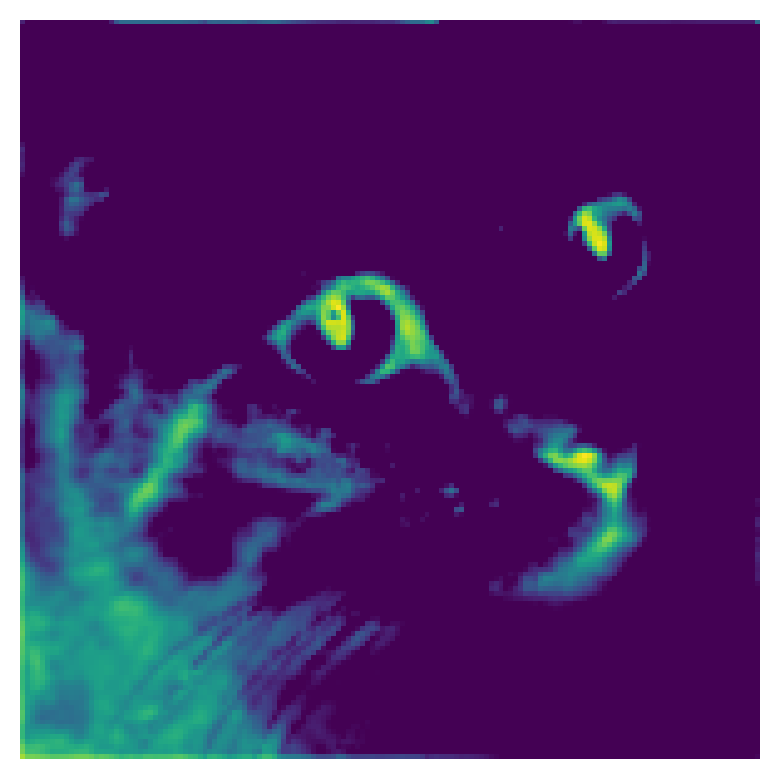

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


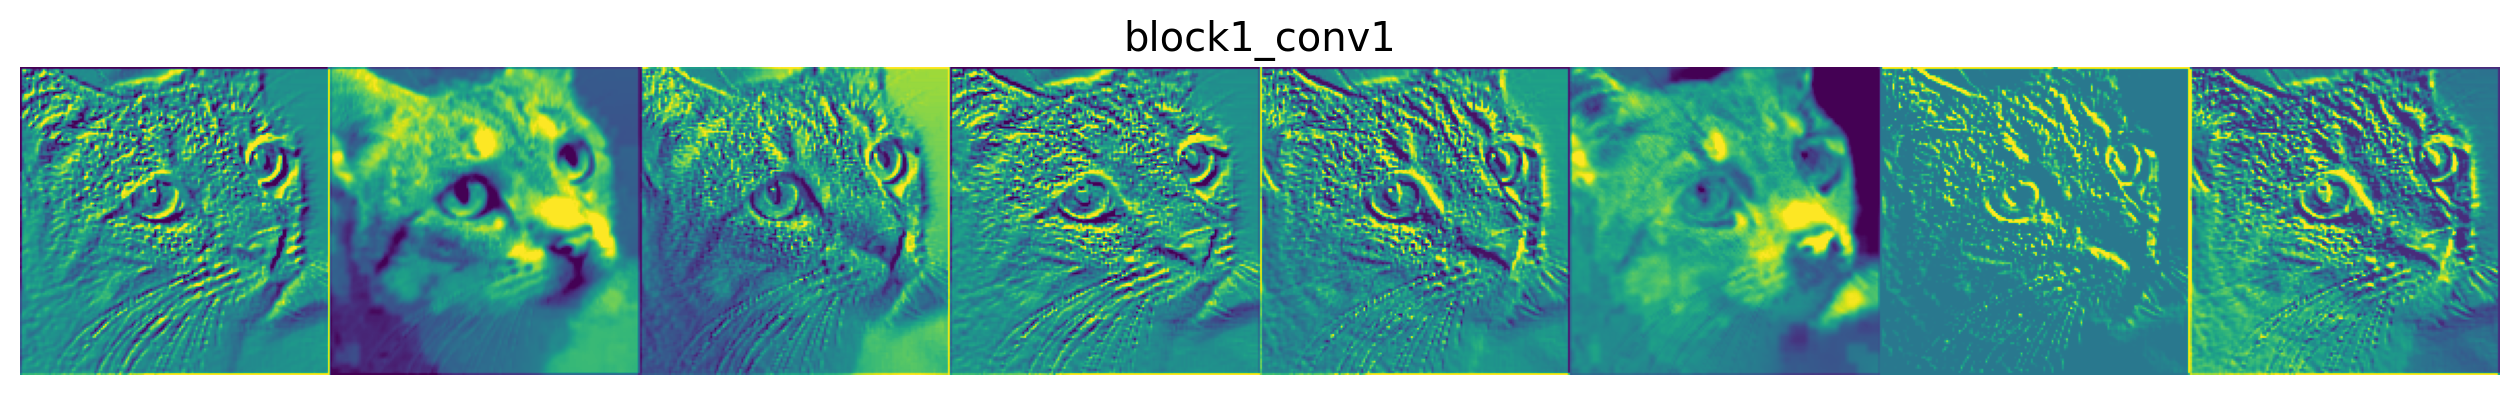

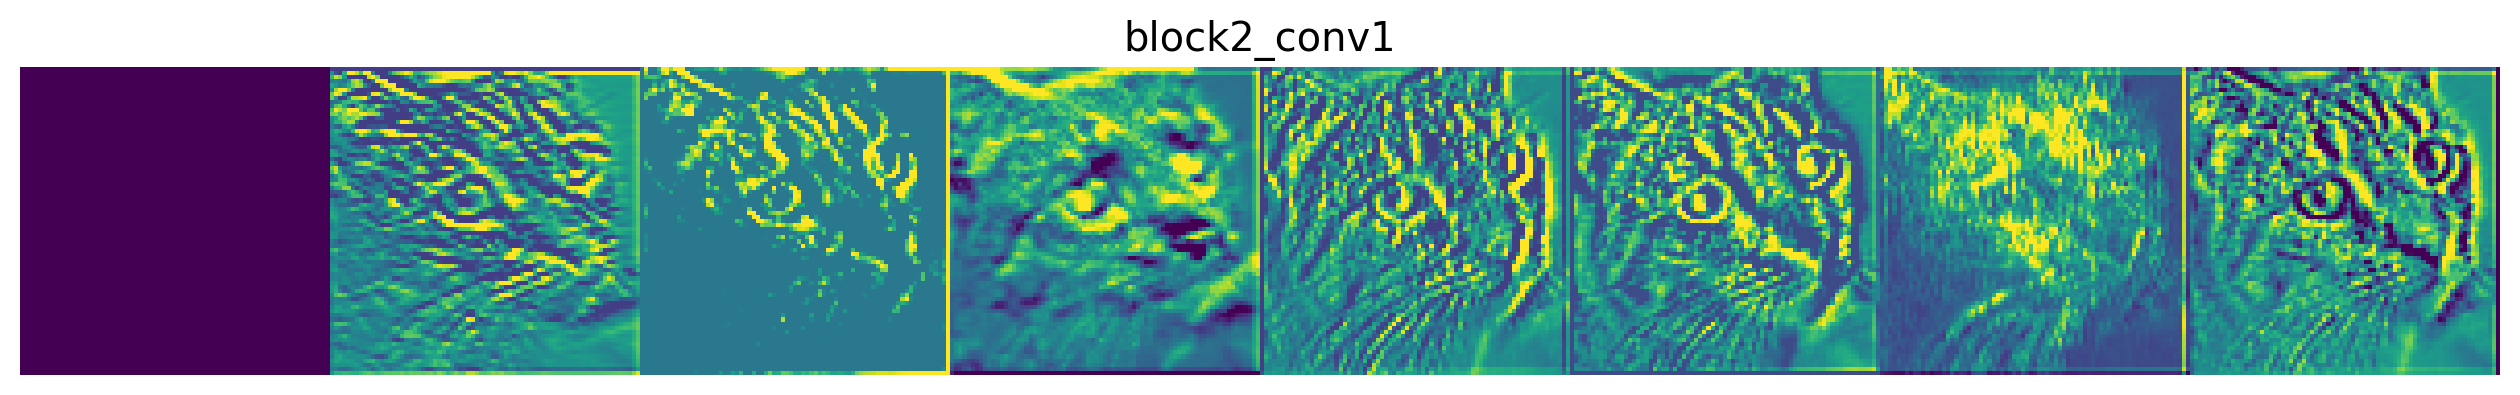

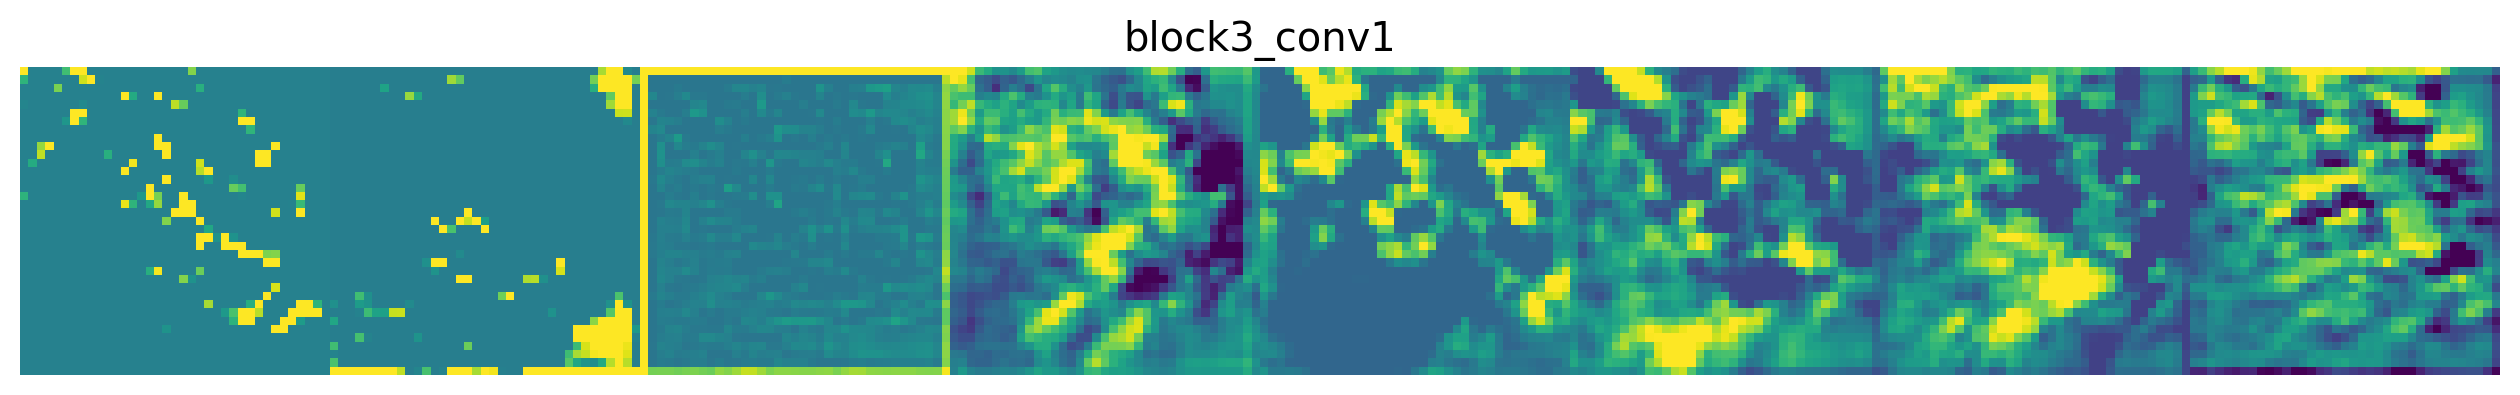

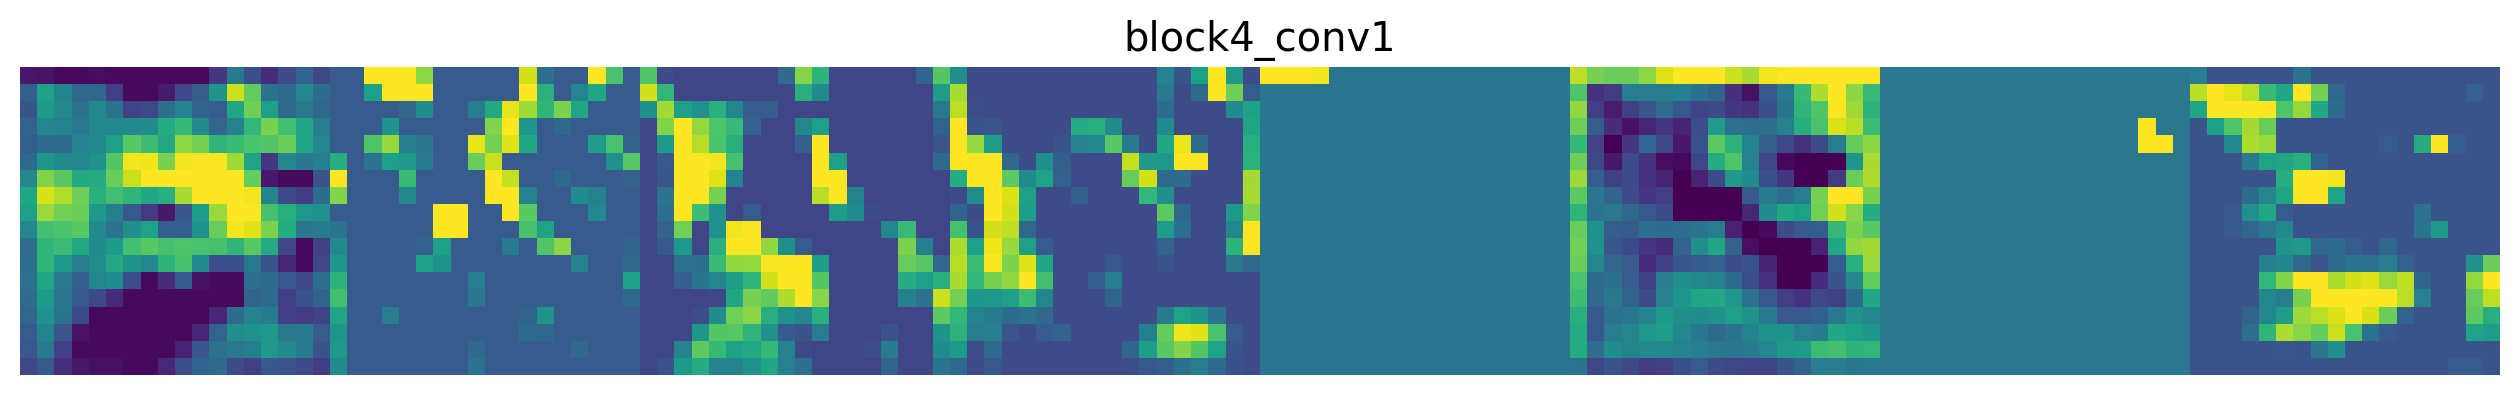

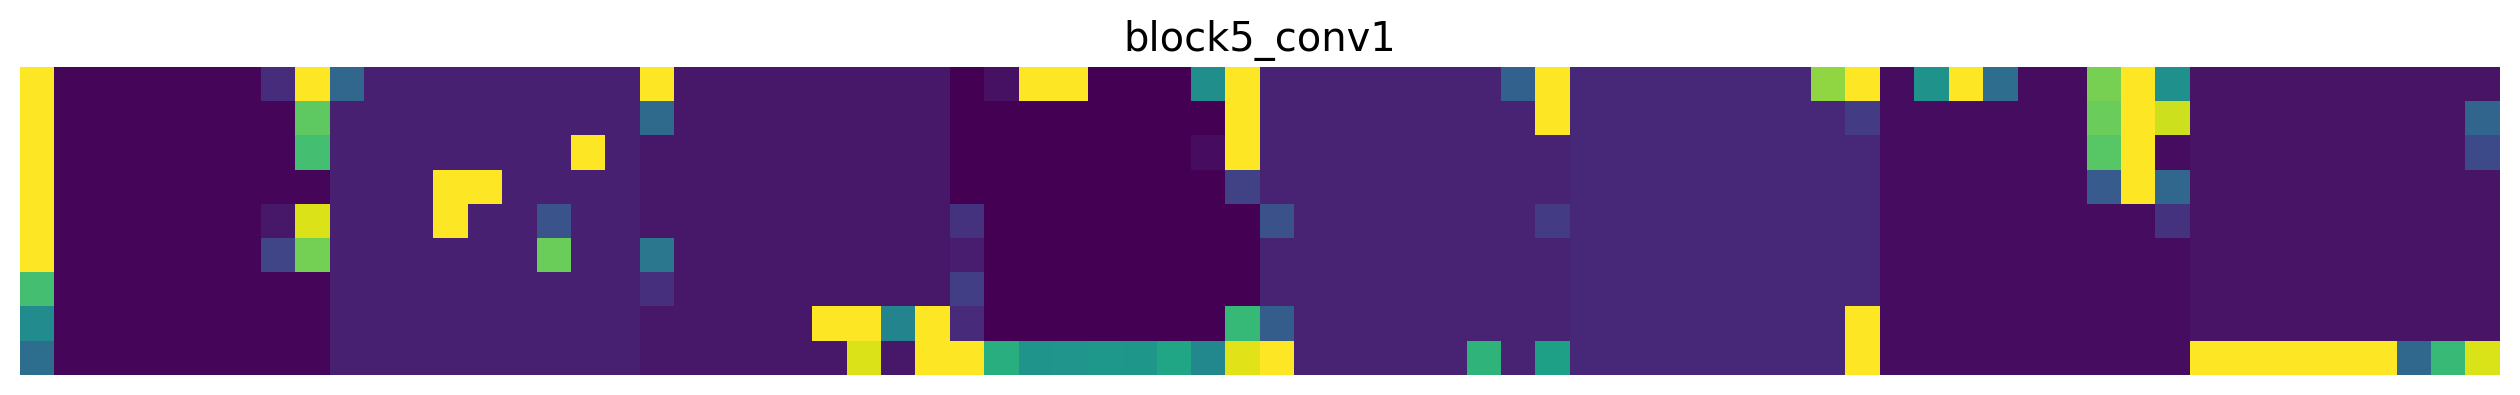

In [ ]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - Score: 66.9378 - TotalVariation2D: 6.5969 - Norm: 38.1135


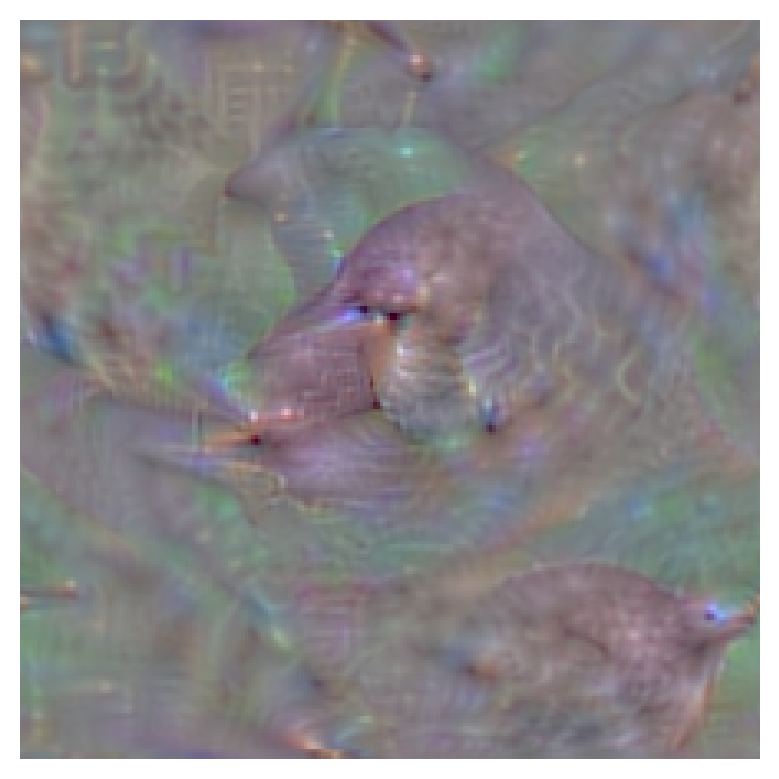

In [26]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16 as Model
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter,Rotate2D
from tf_keras_vis.activation_maximization.regularizers import Norm, TotalVariation2D
import matplotlib.pyplot as plt

# Cargar el modelo VGG16 preentrenado
model = Model(weights='imagenet', include_top=True)

# Nombre de la capa convolucional que se va a visualizar
layer_name = 'predictions'

# Modificador del modelo: cambia la activación a lineal en la capa objetivo
def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

model = model_modifier_function(model)
replace2linear = ReplaceToLinear()
# Número del filtro que se quiere visualizar (0-511)
filter_number = 20

# Función de puntuación: define el filtro a maximizar
def score_function(output):
    return output[..., filter_number]

# Crear una instancia de ActivationMaximization
activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)

# Generar la activación maximizada
activations = activation_maximization(score_function, callbacks=[Progress()], seed_input=None)

# Convertir la imagen a un formato adecuado para visualizar con Matplotlib
img = activations[0]  # img es una lista con una sola imagen
img = np.uint8(img)  # Convertir a uint8 para asegurar que esté en el rango 0-255

# Visualizar la imagen
plt.imshow(img)
plt.axis('off')  # Opcional: oculta los ejes
plt.show()

800/800 ━━━━━━━━━━━━━━━━━━━━ 56s 70ms/step - Score: 176.3858 - TotalVariation2D: 6.1914 - Norm: 38.2306


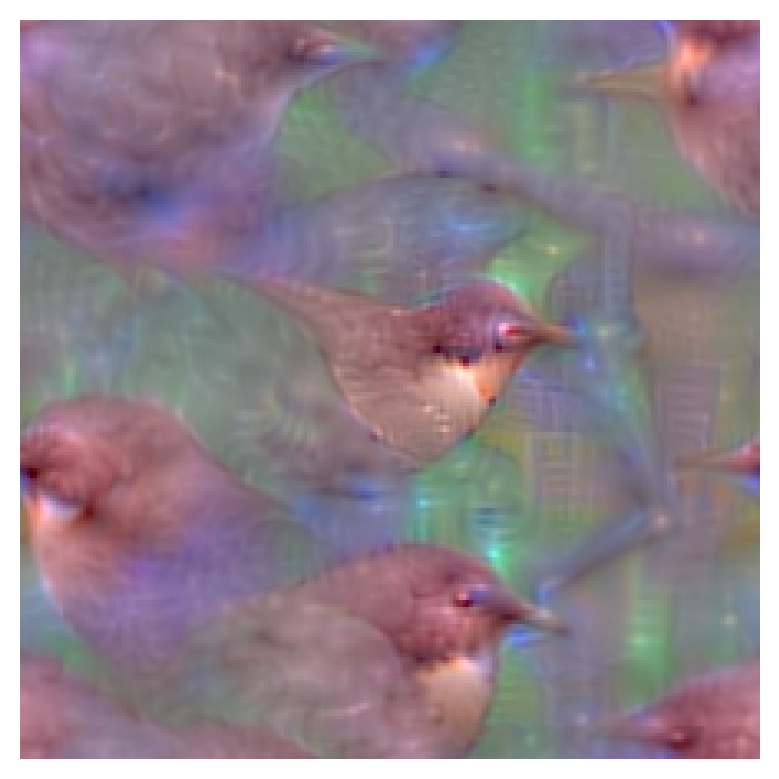

In [32]:
# Cargar el modelo VGG16 preentrenado
model = Model(weights='imagenet', include_top=True)

# Nombre de la capa convolucional que se va a visualizar
layer_name = 'predictions'

# Modificador del modelo: cambia la activación a lineal en la capa objetivo
def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

model = model_modifier_function(model)
replace2linear = ReplaceToLinear()

# Número del filtro que se quiere visualizar (0-511)
filter_number = 20

# Función de puntuación: define el filtro a maximizar
def score_function(output):
    return output[..., filter_number]

# Crear una instancia de ActivationMaximization sin `input_modifiers`
activation_maximization = ActivationMaximization(model, 
                                                 model_modifier=replace2linear)

# Generar la activación maximizada
activations = activation_maximization(score_function, 
                                      callbacks=[Progress()], 
                                      seed_input=None,
                                      steps=800,
                                      input_modifiers = [Jitter(jitter=16), Rotate2D(degree=0.5)])  # Sin regularizadores


# Convertir la imagen a un formato adecuado para visualizar con Matplotlib
img = activations[0]  # img es una lista con una sola imagen
img = np.uint8(img)  # Convertir a uint8 para asegurar que esté en el rango 0-255

# Visualizar la imagen
plt.imshow(img)
plt.axis('off') 
plt.show()

In [21]:
# Cargar el modelo VGG16 preentrenado
model = Model(weights='imagenet', include_top=True)

# Nombre de la capa convolucional que se va a visualizar
layer_name = 'predictions'

# Modificador del modelo: cambia la activación a lineal en la capa objetivo
def model_modifier_function(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

model = model_modifier_function(model)
replace2linear = ReplaceToLinear()

# Función de puntuación: define el filtro a maximizar
def score_function(output, filter_number):
    return output[..., filter_number]

# Instancia de ActivationMaximization con los modificadores y regularizadores que utilizaste anteriormente
activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)

# Lista de nombres y códigos de las imágenes a generar
codes = '''
rabbit 330
crocodile 49
starfish 327
husky 248
goldfish 1
bridge 839
balloon 417
tennis ball 852
gondola 576
dumbbell 543
hammer 587
lamp 846
'''

images = []
tuples = []

# Generar imágenes iniciales y guardarlas en la lista `images`
for line in codes.split('\n'):
    if not line:
        continue
    name, idx = line.rsplit(' ', 1)
    idx = int(idx)
    
    # Generar activación
    activations = activation_maximization(lambda x: score_function(x, idx), 
                                          steps=300,
                                          input_modifiers=[Jitter(jitter=16), Rotate2D(degree=0.75)],
                                          regularizers=[TotalVariation2D(weight=3), Norm(weight=0.5)])
    
    img = activations[0]
    img = np.uint8(img)  # Convertir la imagen a uint8 para asegurar el rango 0-255

    # Añadir texto (nombre) a la imagen usando matplotlib
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(name)
    ax.axis('off')
    
    # Convertir la imagen con el nombre a un array y agregarla a la lista
    fig.canvas.draw()
    img_with_text = np.array(fig.canvas.renderer.buffer_rgba())
    images.append(img_with_text)
    plt.close(fig)

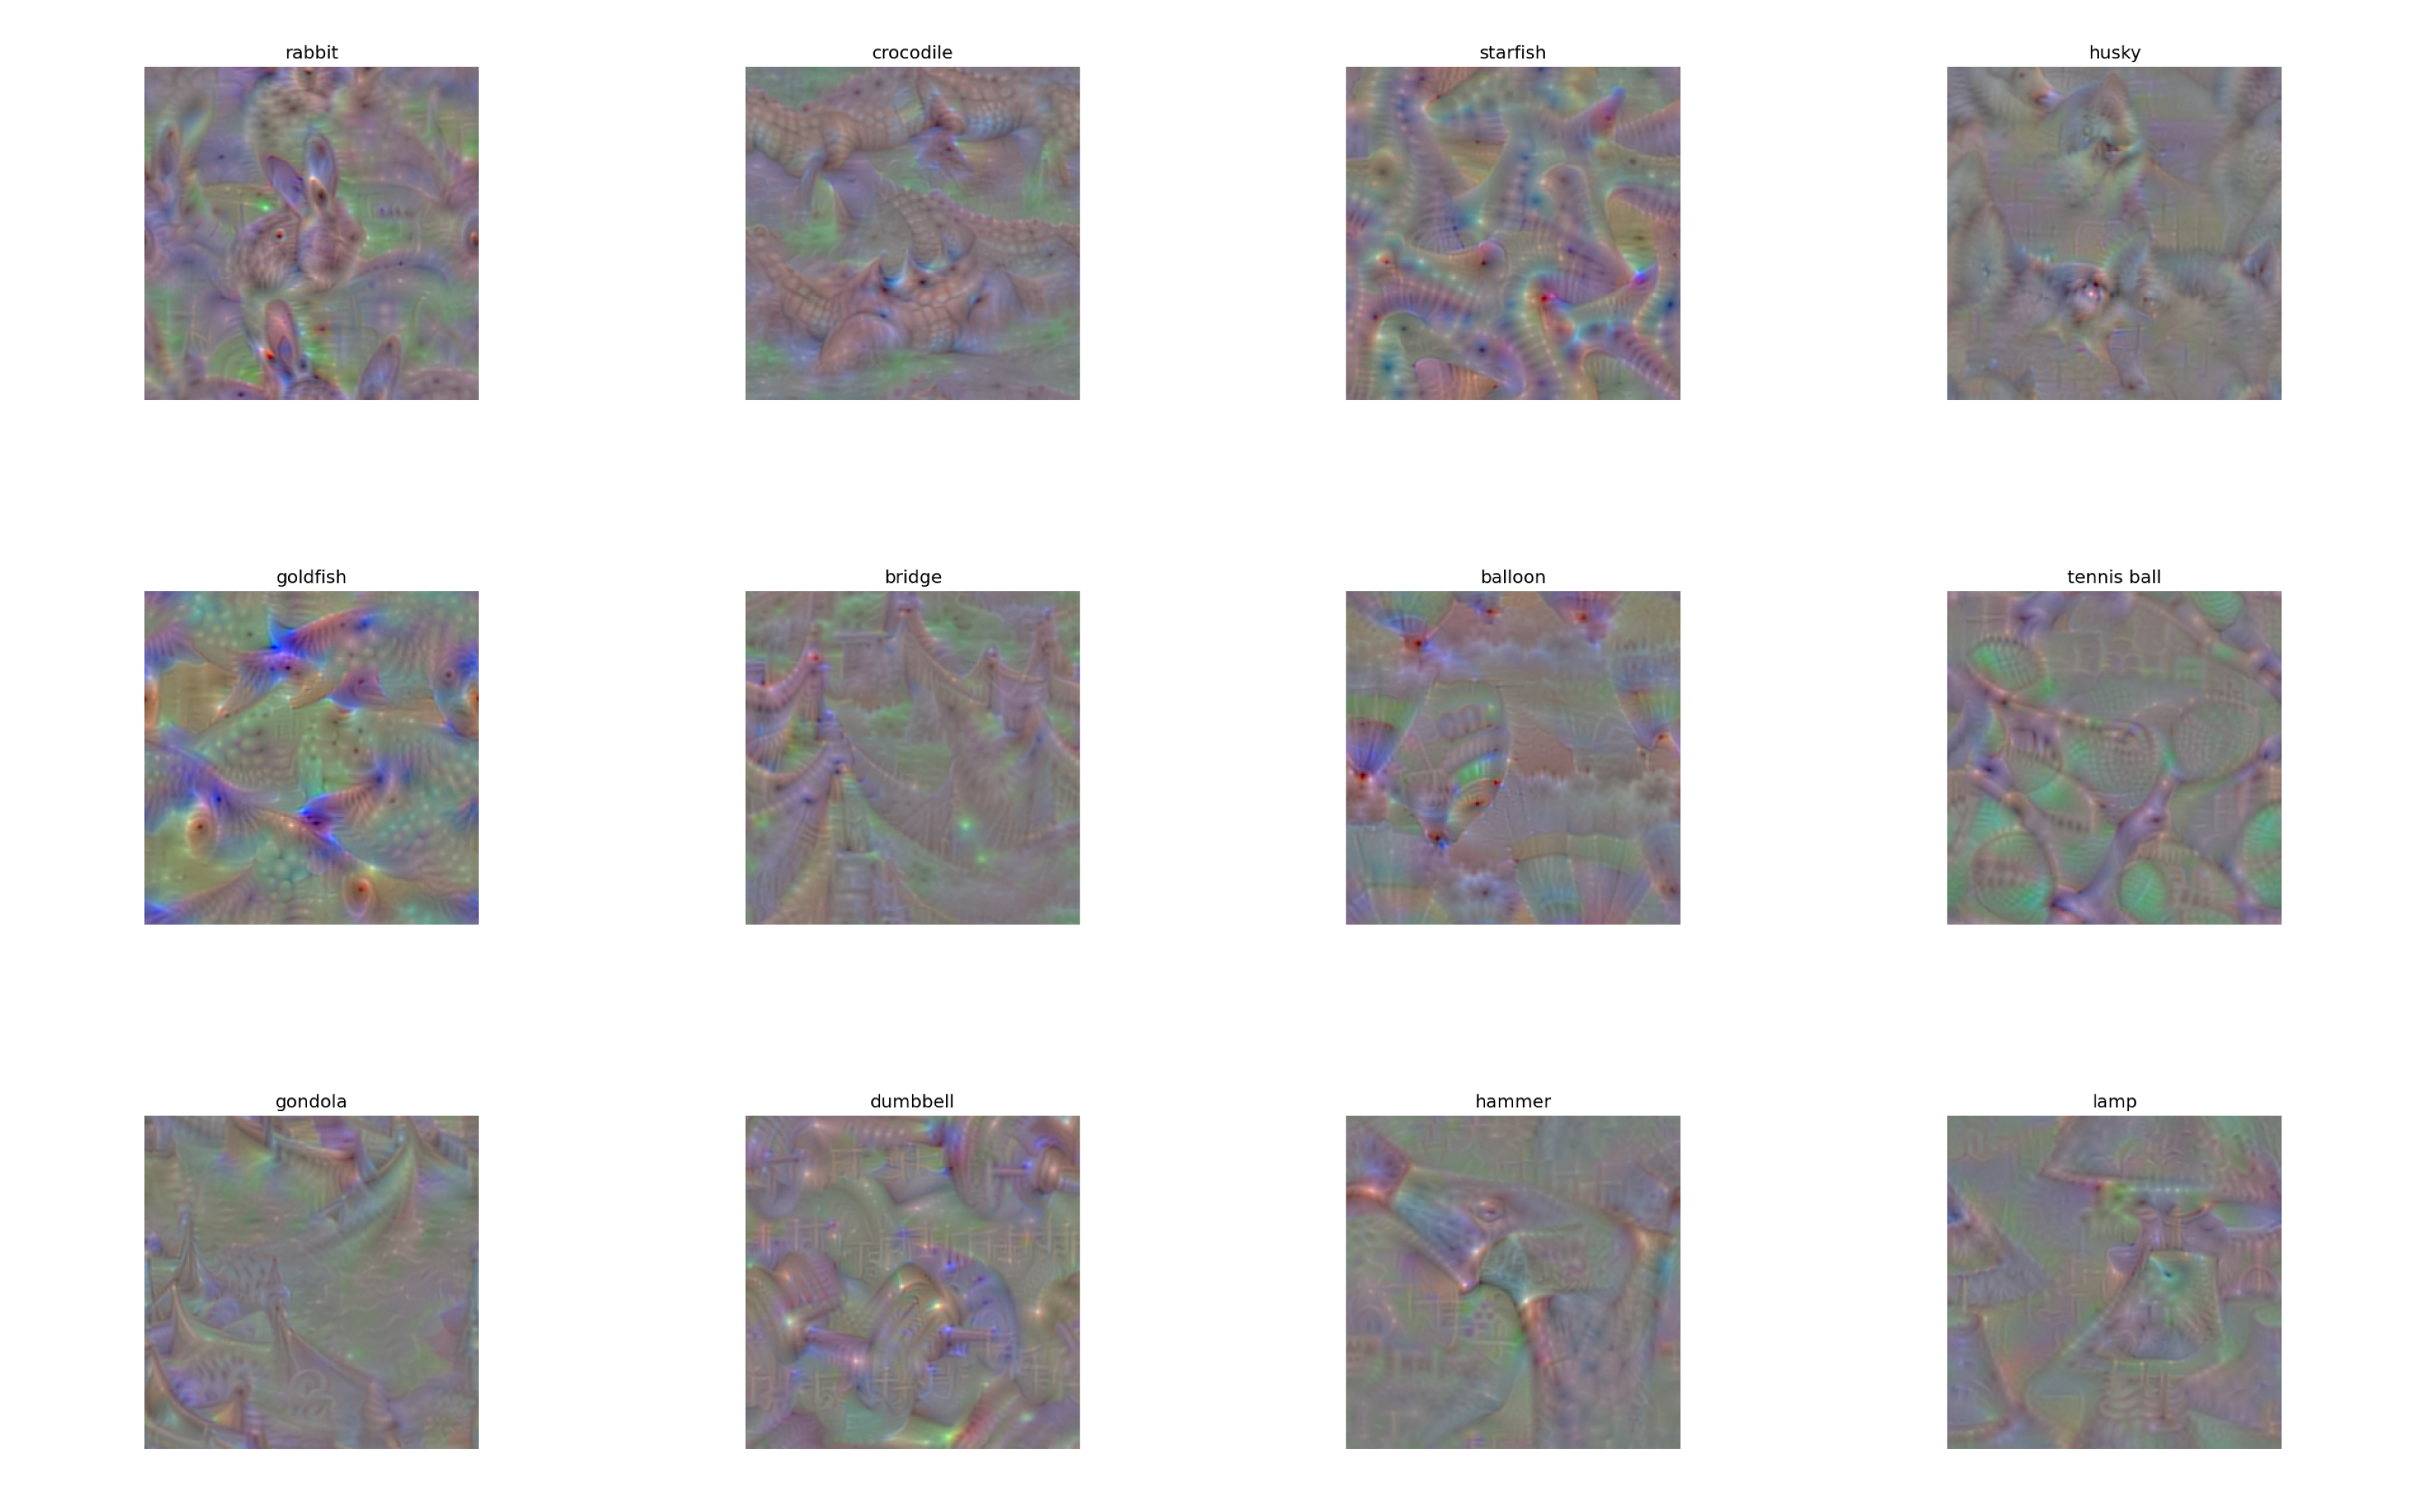

In [22]:
# Unir imágenes en una matriz 3x4 y mostrar
fig, axes = plt.subplots(3, 4, figsize=(16, 11))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()